# Lecture 12: Neural Networks

Imports and Helper Functions
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
from subprocess import call
import ipywidgets as widgets
from IPython.display import display
from sklearn import datasets as skdatasets
from ipywidgets import interactive_output

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

#import warnings
#warnings.filterwarnings('ignore')

%matplotlib notebook

## Model Creation

In [2]:
#Define a basic MLP with pyTorch
class MLP(nn.Module):
    def __init__(self, K):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, K)
        self.out = nn.Linear(K, 1)
        self.ceriation = nn.BCELoss()

    def _predict_proba(self, X):
        h1 = torch.sigmoid(self.fc1(X))
        yhat = torch.sigmoid(self.out(h1))
        return yhat

    def forward(self, X, y):
        yhat = self._predict_proba(X)
        loss = self.ceriation(yhat, y)
        return loss

    def predict_proba(self, X):
        X = Variable(torch.from_numpy(X).float())
        yhat = self._predict_proba(X)
        return yhat.data.numpy()

    def fit(self, X, y, verbose=False):
        X2 = torch.from_numpy(X).float()
        y2 = torch.from_numpy(y[:, np.newaxis]).float()
        optimizer = optim.Adam(self.parameters(), lr=0.1, weight_decay=1e-4)

        old_loss = np.inf
        for epoch in range(100):
            optimizer.zero_grad()
            loss = self(Variable(X2), Variable(y2))
            loss.backward()
            optimizer.step()
            if np.abs(loss.data.item() - old_loss) / np.abs(loss.data.item()) < 1e-6:
                break
            old_loss = loss.data.item()
            if verbose:
                print('==>>> epoch: {}, train loss: {:.6f}'.format(epoch, loss.data.item()))
        print('==>>> epoch: {}, train loss: {:.6f}'.format(epoch, loss.data.item()))

## Dataset Generation

In [3]:
N = 100
datasets = {}

X = np.vstack((2.5 * np.random.randn(int(N / 2), 2) - 5, (2.5 * np.random.randn(int(N / 2), 2) + 5)))
y = np.hstack((-1 * np.ones((int(N / 2))), np.ones((int(N / 2)))))
ind = np.random.permutation(range(N))
datasets["Dataset 1"] = (X[ind, :], y[ind])

In [4]:
iris = skdatasets.load_iris()
X = iris.data[:, :2][:100]  # we only take the first two features. First 100 examples have only 2 classes.
y = iris.target[:100]
y[(y == 0)] = -1  # convert 0 class label to -1.
ind = np.random.permutation(range(100))  # indices to shuffle the data.
X = X[ind, :]
y = y[ind]

# Rescale the data to [-9, 9] range.
old_min, old_max = np.min(X[:, 0]), np.max(X[:, 0])
old_range = old_max - old_min
X[:, 0] = (X[:, 0] - old_min) * 18 / old_range + (-9)

old_min, old_max = np.min(X[:, 1]), np.max(X[:, 1])
old_range = old_max - old_min
X[:, 1] = (X[:, 1] - old_min) * 18 / old_range + (-9)

datasets["Dataset 2"] = X, y

In [5]:
X, y = skdatasets.make_moons(n_samples=N, shuffle=True, noise=0.2, random_state=None)
y[(y == 0)] = -1

# Rescale the data to [-9, 9] range.
old_min, old_max = np.min(X[:, 0]), np.max(X[:, 0])
old_range = old_max - old_min
X[:, 0] = (X[:, 0] - old_min) * 18 / old_range + (-9)

old_min, old_max = np.min(X[:, 1]), np.max(X[:, 1])
old_range = old_max - old_min
X[:, 1] = (X[:, 1] - old_min) * 18 / old_range + (-9)

datasets["Dataset 3"] = X, y

In [6]:
# generate points for the four quadrants
n_4 = int(N / 4)
x1 = np.random.normal(loc=[5, 5], scale=2, size=(n_4, 2))
x2 = np.random.normal(loc=[-5, 5], scale=2, size=(n_4, 2))
x3 = np.random.normal(loc=[-5, -5], scale=2, size=(n_4, 2))
x4 = np.random.normal(loc=[5, -5], scale=2, size=(n_4, 2))

# make quadrant 1 and 3 as -1 label, 2 and 4 as +1 label.
X = np.vstack((x1, x3, x2, x4))
y = np.hstack((-1 * np.ones(n_4 * 2), np.ones(n_4 * 2)))

ind = np.random.permutation(range(N))  # indices to shuffle the data.
X = X[ind, :]
y = y[ind]

datasets["Dataset 4"] = X, y

In [7]:
# Generate 4 separate lines data
n_4 = int(N / 4)

x10 = np.random.uniform(-9.5, -5, n_4)
x11 = x10 + 13 + np.random.uniform(0, 2, n_4)
x1 = np.squeeze(np.dstack((x10, x11)))

x30 = np.random.uniform(0, 8.5, n_4)
x31 = x30 - 5 + np.random.uniform(0, 2, n_4)
x3 = np.squeeze(np.dstack((x30, x31)))

x20 = np.random.uniform(-9.5, -1, n_4)
x21 = x20 + 5 + np.random.uniform(0, 2, n_4)
x2 = np.squeeze(np.dstack((x20, x21)))

x40 = np.random.uniform(5, 9.5, n_4)
x41 = x40 - 13 - np.random.uniform(0, 2, n_4)
x4 = np.squeeze(np.dstack((x40, x41)))

X = np.vstack((x1, x3, x2, x4))
y = np.hstack((-1 * np.ones(n_4 * 2), np.ones(n_4 * 2)))

datasets["Dataset 5"] = X, y

## Plotting Function

In [8]:
def plot_nn_classifier(dataset='Dataset 1', N=10, K=5):
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 12})

    if dataset is not None and N > 0:
        # Gather dataset

        X, Y = datasets[dataset]
        X = X[:N]
        Y = Y[:N]
        Y[Y == -1] = 0  # change Y labels to be sigmoid compatible

        # Plot original data

        ind1 = (Y == 1)
        indm1 = (Y == 0)
        plt.plot(X[ind1, 0], X[ind1, 1], 'bs', alpha=0.5)
        plt.plot(X[indm1, 0], X[indm1, 1], 'rs', alpha=0.5)

        # Create the classifier

        model = MLP(K)
        model.fit(X, Y)

        # Calculate prediction error

        Yprob = np.reshape(model.predict_proba(X), -1)
        Yhat = 1 * (Yprob >= 0.5)
        R = np.mean(Yhat != Y)

        # Create contours for background plot

        gx1, gx2 = np.meshgrid(np.arange(-10, 10, 1 / 10.0), np.arange(-10, 10, 1 / 10.0))
        gx1l = gx1.flatten()
        gx2l = gx2.flatten()
        gx = np.vstack((gx1l, gx2l)).T
        gyhat = model.predict_proba(gx)[:, 0]
        gyhat = gyhat.reshape(gx1.shape)
        #         print('gyhat={}'.format(gyhat))

        if (not all(gyhat.flatten() == 0)):
            contours = plt.contour(gx1, gx2, gyhat, levels=[0.5], linewidths=2, colors=["k"])
            plt.imshow(gyhat, interpolation='nearest', extent=(-10, 10, -10, 10), aspect='auto', origin='lower',
                       cmap=plt.cm.bwr_r, alpha=0.90)
            plt.clim(-10, 10)
            plt.colorbar()

        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.title("MLP classifier. Error rate: {:.4g}".format(R))
        plt.xlabel("X0")
        plt.ylabel("X1")
        plt.grid(True)
        plt.legend(["Class 1", "Class -1"], loc='upper left')
        plt.show()

<IPython.core.display.Javascript object>


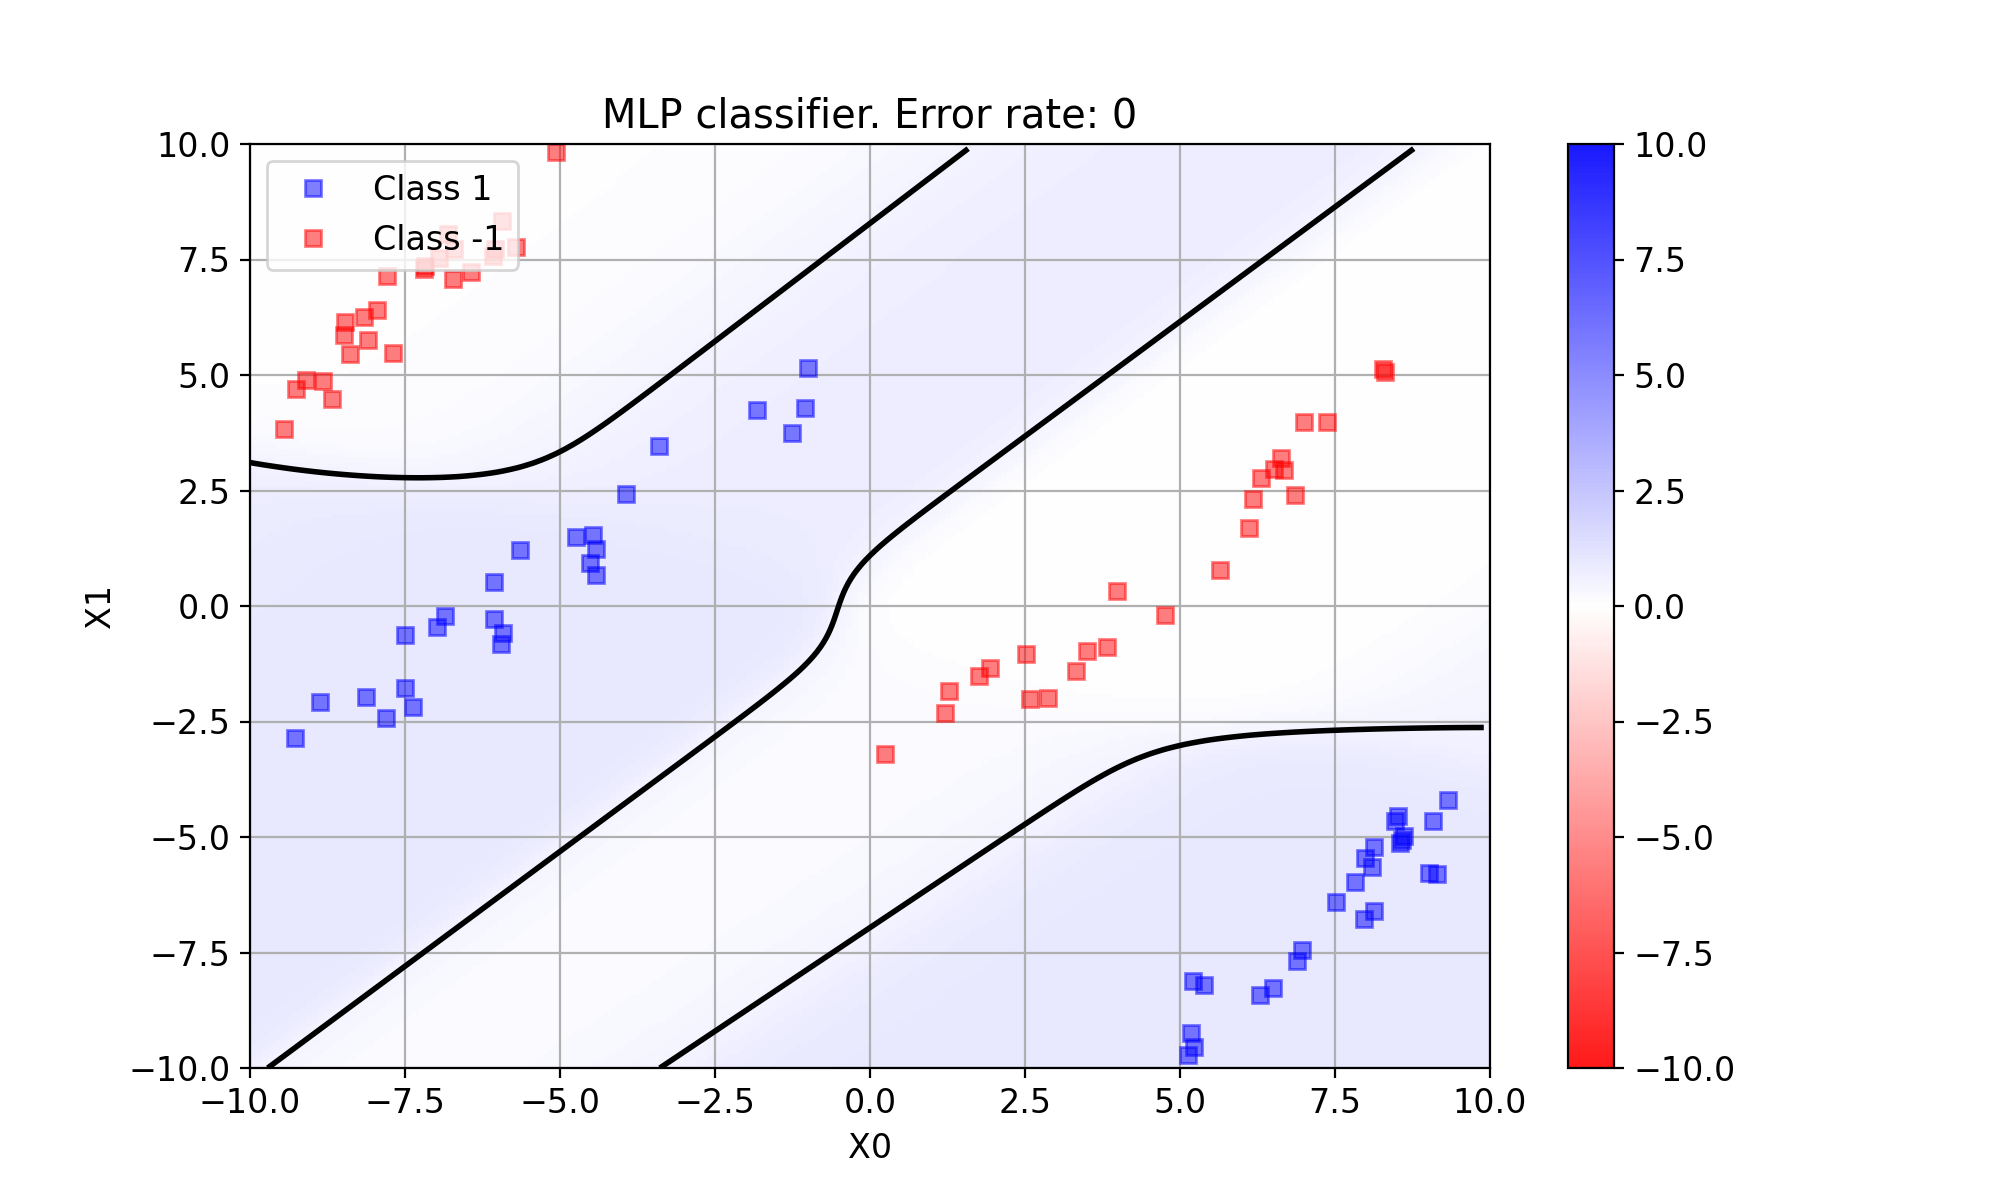

==>>> epoch: 99, train loss: 0.064433


In [9]:
plot_nn_classifier(dataset="Dataset 5", N=100, K=5)

In [10]:
wd = widgets.Dropdown(
    options=["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4", "Dataset 5"],
    description="Dataset"
)
wn = widgets.IntSlider(value=10, min=1, max=N, step=1, description="N", continuous_update=False)
wk = widgets.IntSlider(
    value=1,
    min=1,
    max=50,
    step=1,
    description='Hiddel units K:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)

out = interactive_output(
    plot_nn_classifier,
    {
        "dataset": wd,
        "N": wn,
        "K": wk,
    }
)

out.layout.height = '400px'
box1 = widgets.HBox([wd, wn, wk])
ui = widgets.VBox([box1]);

In [11]:
display(out, ui)

Output(layout=Layout(height='400px'))

### Interactive Mode (only for local jupyter notebook)

In [12]:
def plot2d_data(x, y, data_name, class_names, feature_names, markers=['sr', '^b', 'og']):
    """Plot a 2d data set. x must be an Nx2 array of feature values. 
    y must be a N-long array of label values. data_name is a 
    string giving the name of the data set. The class labels
    must be intergers between 1 and C. class_names must be a 
    list of strings naming the classes. feature_names must be a
    list of strings naming the features."""

    for i in np.arange(len(class_names)):
        plt.plot(x[y == i, 0], x[y == i, 1], markers[i], alpha=0.8);


def interactive_classifier(clf):
    """Define an interactive classifier. clf can be any classifier
    object that implements predict. fig must be a figure handle
    to a 2d data plot created using plot2d_data(). The function
    applies the classifier to the points that you click on and
    plots them in the specified figure.
    """

    #Define the event handler
    def onclick(event):
        global N
        global x_tr
        global y_tr
        global dclass
        global clf
        markers = ['sr', '^b', 'og']
        #Get the point that is clicked on
        x = np.array([event.xdata, event.ydata])

        x_tr[N, :] = x
        y_tr[N] = dclass
        N = N + 1

        plt.clf()
        plot_prob_classifier(clf, x_tr[:N, :], y_tr[:N], "Interactive Classifier", ["Class 0", "Class 1"], ["X1", "X2"])

    #Create a callback to connect the handler to mouse click events 
    cid = plt.gcf().canvas.mpl_connect('button_press_event', onclick)


#Define classifier plotting function
def plot_prob_classifier(clf, x, y, data_name, class_names, feature_names, show_data=True, markers=['sr', '^b', 'og']):
    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(np.arange(-10, 10, 1 / 100.0), np.arange(-10, 10, 1 / 100.0))

    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx = np.vstack((gx1l, gx2l)).T

    if (N > 0):
        plot2d_data(x, y, data_name, class_names, feature_names, markers=markers)

    if (N > 1 and np.any(y == 1) and np.any(y == 0)):
        #Compute a prediction for every point in the grid
        #global K
        clf.fit(x, y)
        gyhat = 1 - clf.predict_proba(gx)[:, 0]
        gyhat = gyhat.reshape(gx1.shape)
        contours = plt.contour(gx1, gx2, gyhat, levels=[0.5], linewidths=2, colors=["k"])
        plt.imshow(gyhat, interpolation='nearest',
                   extent=(-10, 10, -10, 10), aspect='auto',
                   origin='lower', cmap=plt.cm.bwr, alpha=0.25)

    else:
        gx1[:] = 0.5
        plt.imshow(gx1, interpolation='nearest',
                   extent=(-10, 10, -10, 10), aspect='auto',
                   origin='lower', cmap=plt.cm.bwr, alpha=0.25)

    plt.legend(class_names)
    plt.clim(0, 1)
    plt.xlim((-10, 10))
    plt.ylim((-10, 10))
    plt.title(data_name)
    plt.grid(True)
    plt.xlabel(feature_names[0]);
    plt.ylabel(feature_names[1]);
    plt.colorbar()


dclass = 0
wclass = widgets.RadioButtons(
    options=['0', '1'],
    description='Class:',
    disabled=False
)

wK = widgets.FloatSlider(
    value=1,
    min=1,
    max=20,
    step=1,
    description='K:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

wbutton = widgets.Button(description="Reset")
wlearn = widgets.Button(description="Learn")
wrand = widgets.Button(description="Randomize")

items1 = [wclass, wK]
items2 = [wlearn, wrand, wbutton]
whbox1 = widgets.HBox(items1)
whbox2 = widgets.HBox(items2)
wvbox = widgets.VBox([whbox1, whbox2])


def on_wclass_change(change):
    global dclass
    print(change)
    dclass = int(change.new)
    print(dclass)


wclass.observe(on_wclass_change, names='value')


def on_wbutton_clicked(b):
    global fig
    init_classifier(fig)


wbutton.on_click(on_wbutton_clicked)


def on_wlearn_clicked(b):
    global x_tr
    global y_tr
    global clf
    global N
    clf.fit(x_tr[:N, :], y_tr[:N])
    plt.clf()
    plot_prob_classifier(clf, x_tr[:N, :], y_tr[:N], "Interactive Classifier", ["Class 0", "Class 1"], ["X1", "X2"])


wlearn.on_click(on_wlearn_clicked)


def on_wrand_clicked(b):
    global x_tr
    global y_tr
    global clf
    global N
    global K
    clf = MLP(K)
    plt.clf()
    plot_prob_classifier(clf, x_tr[:N, :], y_tr[:N], "Interactive Classifier", ["Class 0", "Class 1"], ["X1", "X2"])


wrand.on_click(on_wrand_clicked)


def on_K_change(change):
    global clf
    global fig
    global x_tr
    global y_tr
    global clf
    global N
    global K

    K = int(change.new)
    clf = MLP(K)
    plt.clf()
    plot_prob_classifier(clf, x_tr[:N, :], y_tr[:N], "Interactive Classifier", ["Class 0", "Class 1"], ["X1", "X2"])


wK.observe(on_K_change, names='value')


def init_classifier(fig):
    global N
    global x_tr
    global y_tr
    global clf
    global K
    N = 0
    K = 1
    wK.value = 1
    x_tr = np.zeros((100, 2))
    y_tr = np.zeros(100)
    clf = MLP(K)
    fig.clf()
    plot_prob_classifier(clf, x_tr[:N, :], y_tr[:N], "Interactive Classifier", ["Class 0", "Class 1"], ["X1", "X2"])


In [13]:
'''
Uncomment the below lines if running in a local jupyter notebook. It uses global N variable so messes up with 
plot_nn_classifier(). Use only one at a time.
'''
# display(wvbox)
# fig = plt.figure()
# init_classifier(fig)
# interactive_classifier(fig)

'\nUncomment the below lines if running in a local jupyter notebook. It uses global N variable so messes up with \nplot_nn_classifier(). Use only one at a time.\n'

### Types of Hidden Units

<IPython.core.display.Javascript object>


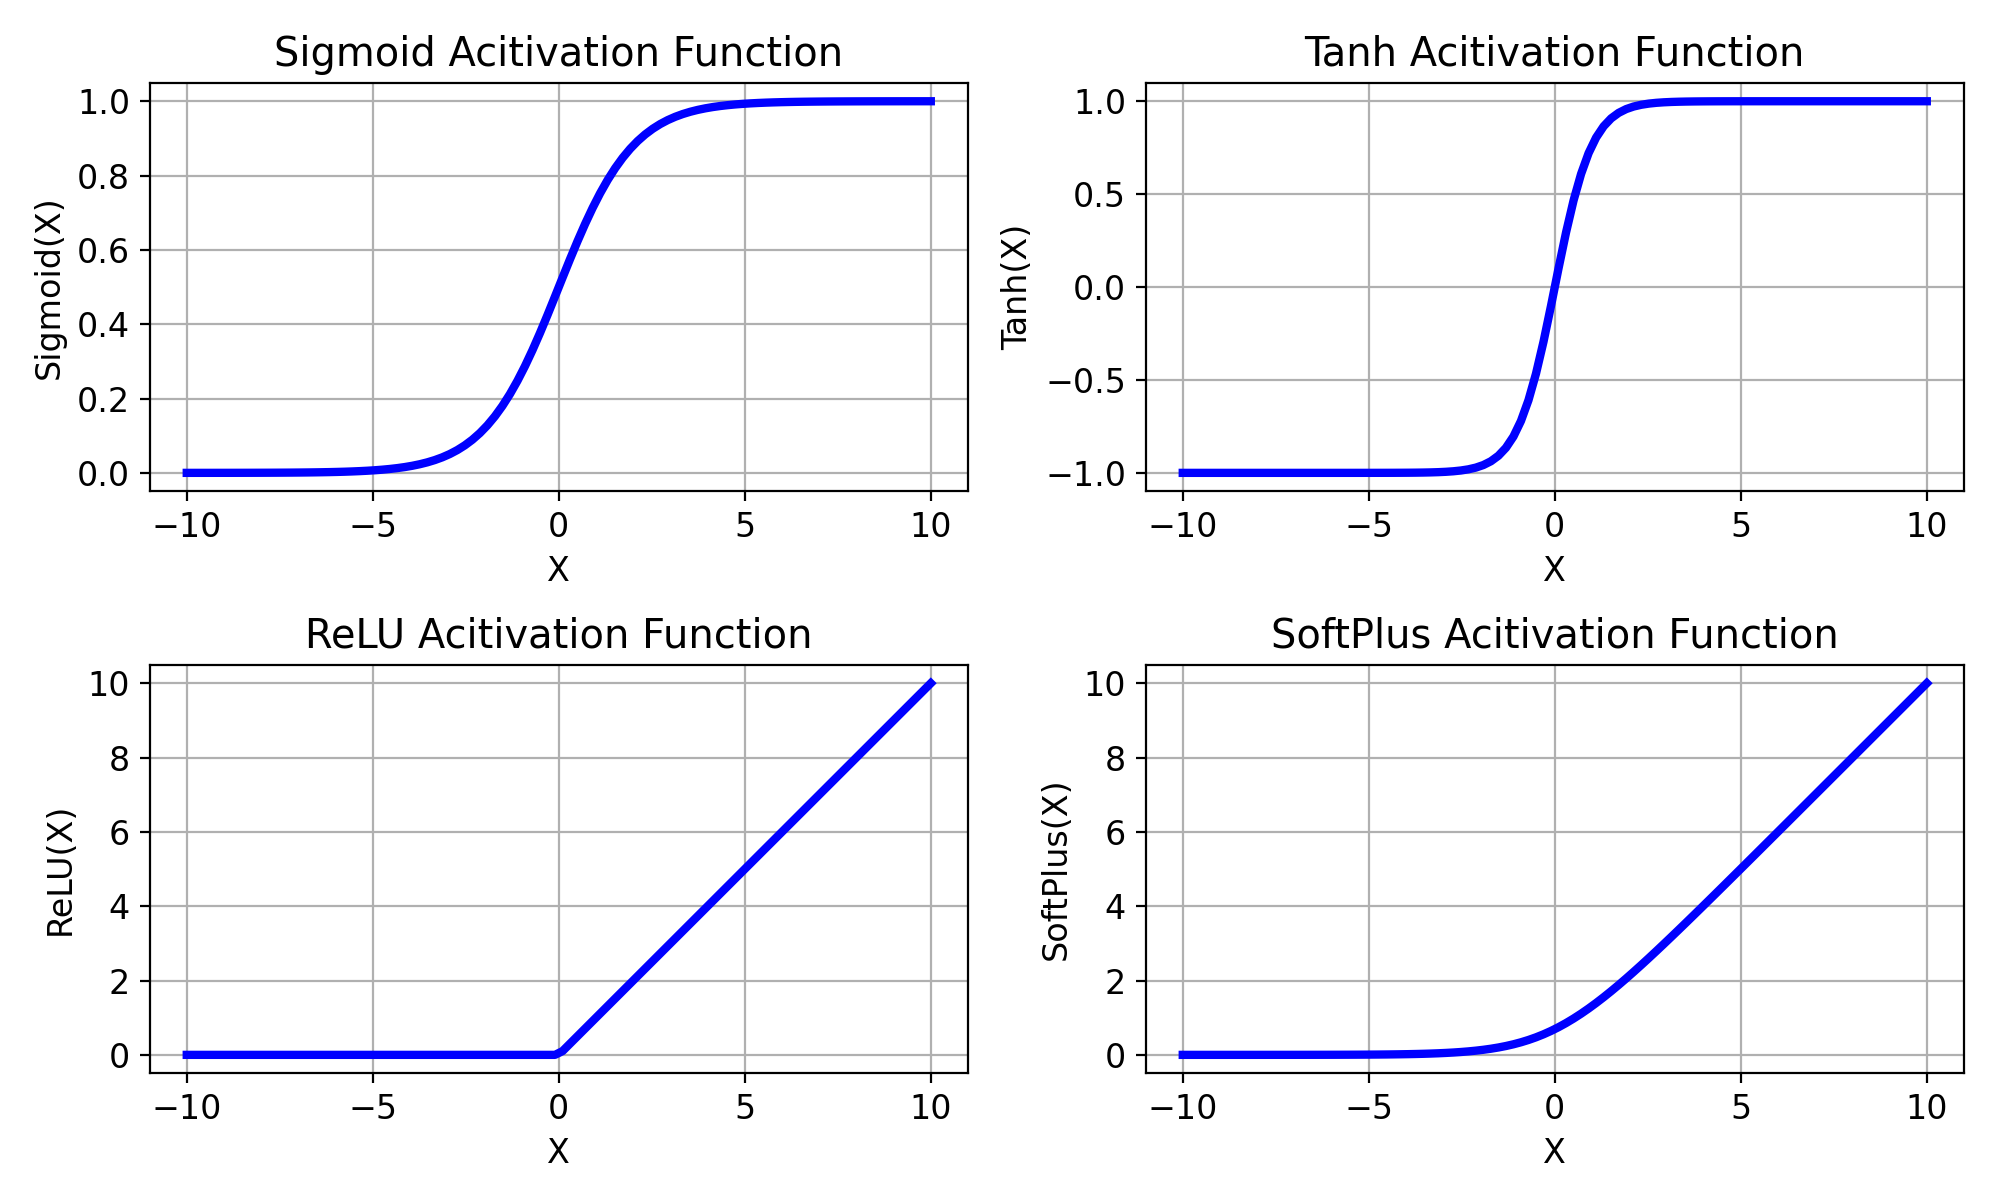

In [14]:
def activation_plot(func, name):
    X = np.linspace(-10, 10, 100)
    Xtv = Variable(torch.from_numpy(X).float())
    Y = func(Xtv).data.numpy()
    plt.plot(X, Y, 'b-', linewidth=3)
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('%s(X)' % (name))
    plt.title("%s Acitivation Function" % (name))


plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
activation_plot(torch.sigmoid, "Sigmoid")
plt.subplot(2, 2, 2)
activation_plot(torch.tanh, "Tanh")
plt.subplot(2, 2, 3)
activation_plot(torch.relu, "ReLU")
plt.subplot(2, 2, 4)
activation_plot(F.softplus, "SoftPlus")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


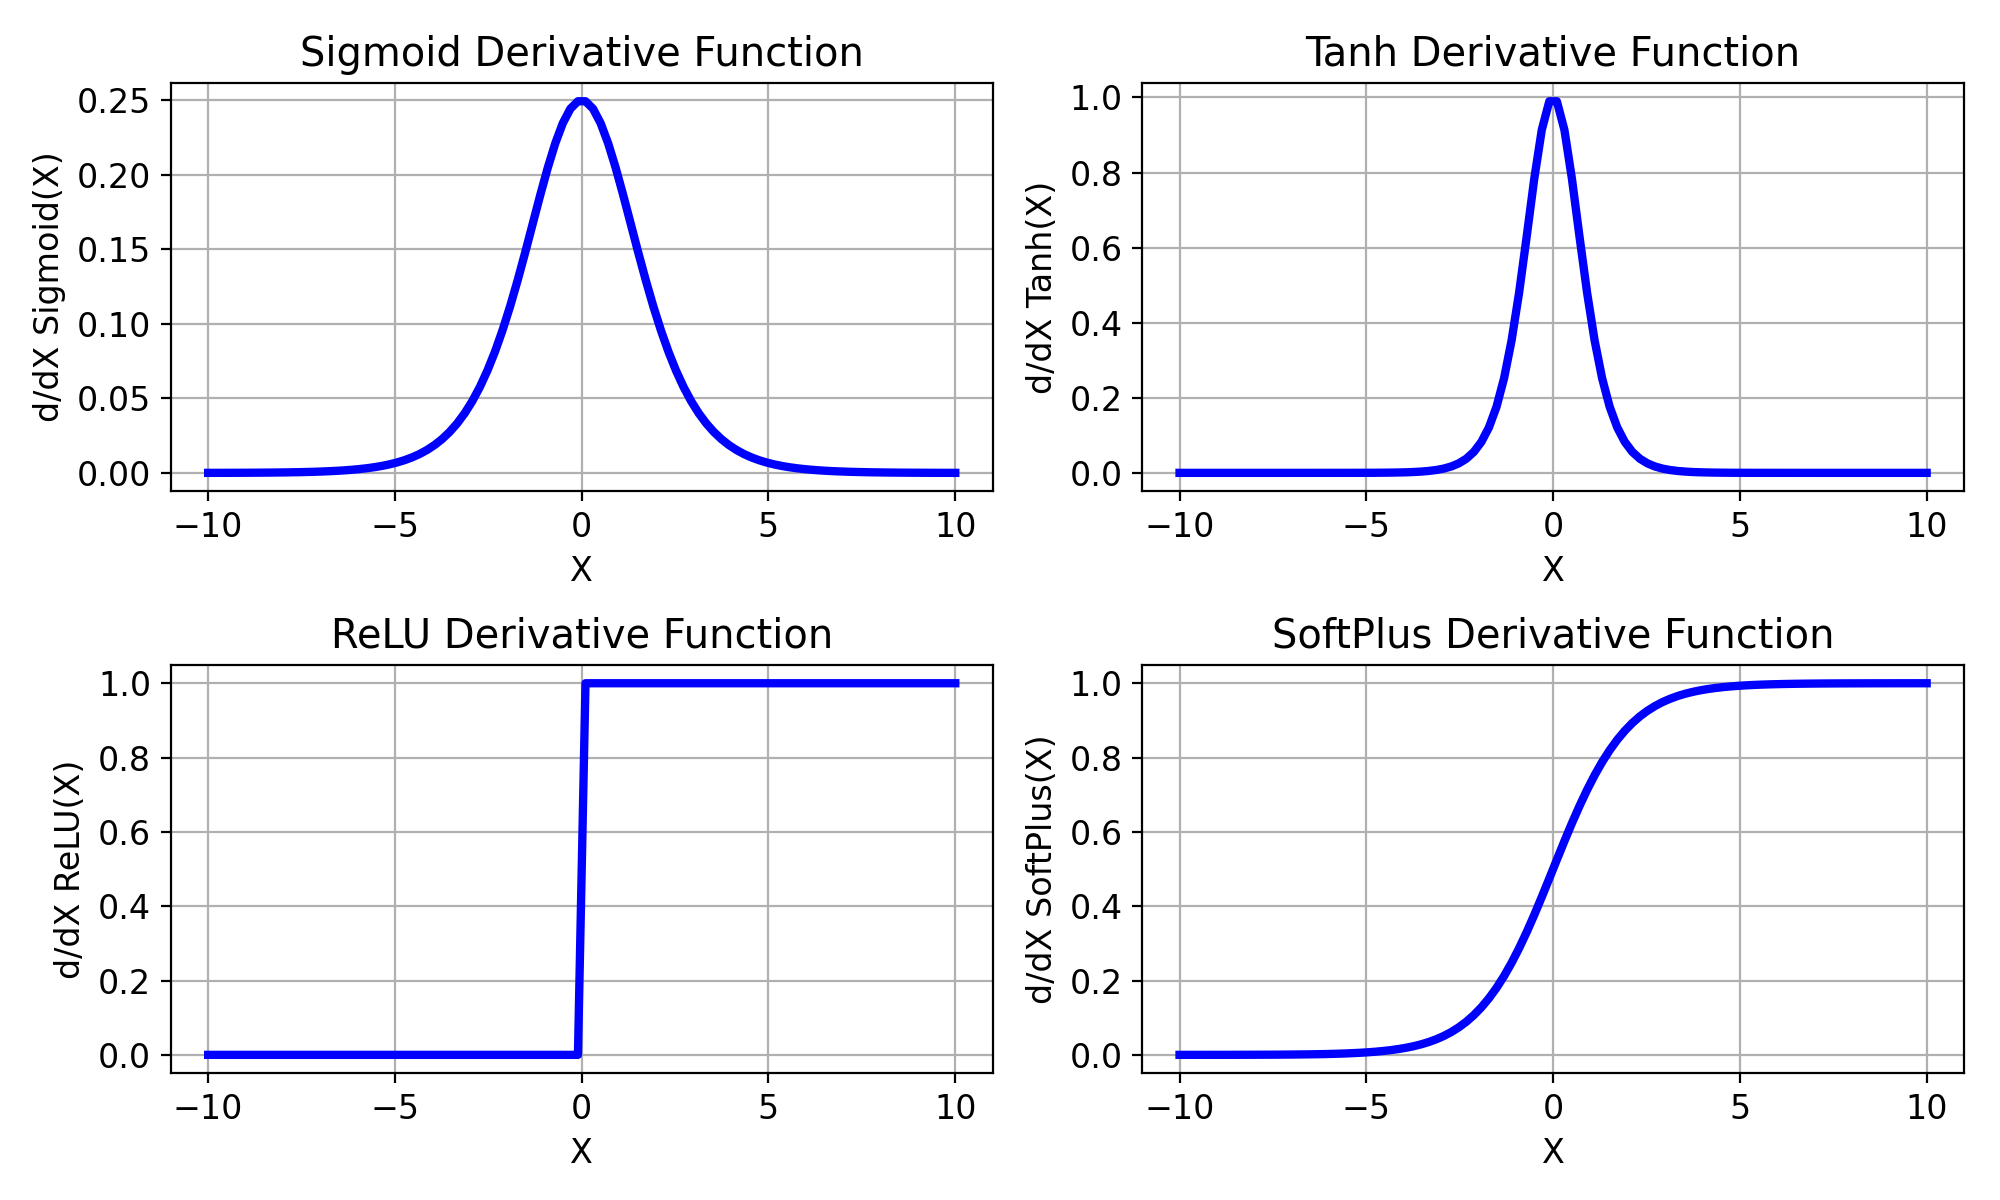

In [15]:
def activation_derivative_plot(func, name):
    X = np.linspace(-10, 10, 100)
    Xtv = Variable(torch.from_numpy(X).float(), requires_grad=True)
    Ytv = func(Xtv)
    Ytv.backward(torch.ones(X.size))
    dYdX = Xtv.grad.data.numpy()
    plt.plot(X, dYdX, 'b-', linewidth=3)
    plt.grid(True)
    plt.xlabel('X')
    plt.ylabel('d/dX %s(X)' % (name))
    plt.title("%s Derivative Function" % (name))


plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
activation_derivative_plot(torch.sigmoid, "Sigmoid")
plt.subplot(2, 2, 2)
activation_derivative_plot(torch.tanh, "Tanh")
plt.subplot(2, 2, 3)
activation_derivative_plot(F.relu, "ReLU")
plt.subplot(2, 2, 4)
activation_derivative_plot(F.softplus, "SoftPlus")
plt.tight_layout()
plt.show()

## Accessing Parameters of Networks

In [16]:
#Create model
mlp = MLP(10)

#Get list of layer modules
mlp._modules

OrderedDict([('fc1', Linear(in_features=2, out_features=10, bias=True)),
             ('out', Linear(in_features=10, out_features=1, bias=True)),
             ('ceriation', BCELoss())])

In [17]:
#Get the first layer weights
mlp._modules['fc1'].weight.data

tensor([[ 0.5984, -0.3598],
        [ 0.5192,  0.6855],
        [ 0.3944,  0.6775],
        [ 0.2934, -0.3365],
        [ 0.0758, -0.1537],
        [-0.4364,  0.2341],
        [ 0.1072,  0.5257],
        [ 0.2655, -0.3204],
        [ 0.1896,  0.3477],
        [-0.1896,  0.6928]])

In [18]:
#Get the first layer biases
mlp._modules['fc1'].bias.data

tensor([ 0.2186, -0.0102, -0.0976,  0.5061, -0.3208,  0.1541,  0.2093,  0.1955,
         0.5908,  0.2873])

In [19]:
#Get the output weights
mlp._modules['out'].weight.data

tensor([[ 0.2525, -0.0167,  0.1584, -0.3003,  0.0257,  0.1577, -0.1536, -0.1771,
          0.0371,  0.1459]])

In [20]:
#Get the output biases
mlp._modules['out'].bias.data

tensor([-0.0993])

In [21]:
#Set the first layer weights
mlp._modules['fc1'].weight.data = torch.ones(10, 2)
#Get the first layer weights
mlp._modules['fc1'].weight.data

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])